# Text classification with Quanvolutional layer + Attention + HQLSTM

# Import libraries

Imports for computations

In [1]:
!pip install custatevec_cu12
!pip install pennylane pennylane-lightning-gpu
import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm.notebook import tqdm

For plotting data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.despine()
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

%matplotlib inline

<Figure size 640x480 with 0 Axes>

For data preprocessing and text cleaning

In [3]:
!pip install langdetect
!pip install contractions
!pip install emoji==1.4.1
!pip install nltk

import re
import string
import emoji
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models import Word2Vec

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Set seed for reproductivity

In [4]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [248]:
num_qubits = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
dev = qml.device("lightning.qubit" if device == "cuda" else "default.qubit", wires=range(num_qubits))
device, dev

('cuda', <lightning.qubit device (wires=4) at 0x7cb244067eb0>)

# Import data, data preprocessing and analysis

We use "Cyberbullying Classification" dataset from Kaggle. You can acquire more information about the data by the following link: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data

In [6]:
df = pd.read_csv('cyberbullying_tweets.csv')

In [7]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [8]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [9]:
df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


Define cleaning functions. Source: https://www.kaggle.com/code/ludovicocuoghi/detecting-bullying-tweets-pytorch-lstm-bert

In [10]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [11]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [12]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [13]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 6301 duplicated tweets, we will remove them.


In [14]:
df.drop_duplicates("text_clean", inplace=True)

In [15]:
df.sentiment.value_counts()

,count
sentiment,
religion,7912
age,7820
ethnicity,7403
gender,7274
not_cyberbullying,6066
other_cyberbullying,4916


As we can see, after cleaning classes are unbalanced so we will drop "other_cyberbullying" class as there is not enough data. Later we will oversample "not_cyberbullying" class.

In [16]:
df = df[df["sentiment"]!="other_cyberbullying"]

In [17]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

<ipython-input-17-fe586f79ef4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = [len(text.split()) for text in df.text_clean]


<ipython-input-18-1c28dcd112f5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


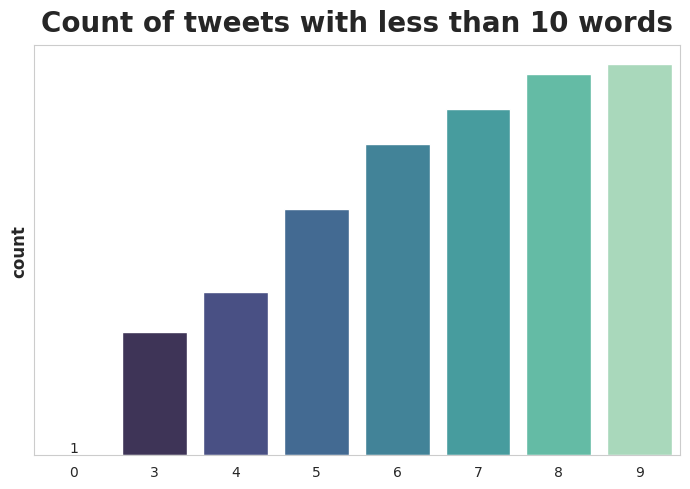

In [18]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

<ipython-input-19-c8466336e1b1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')


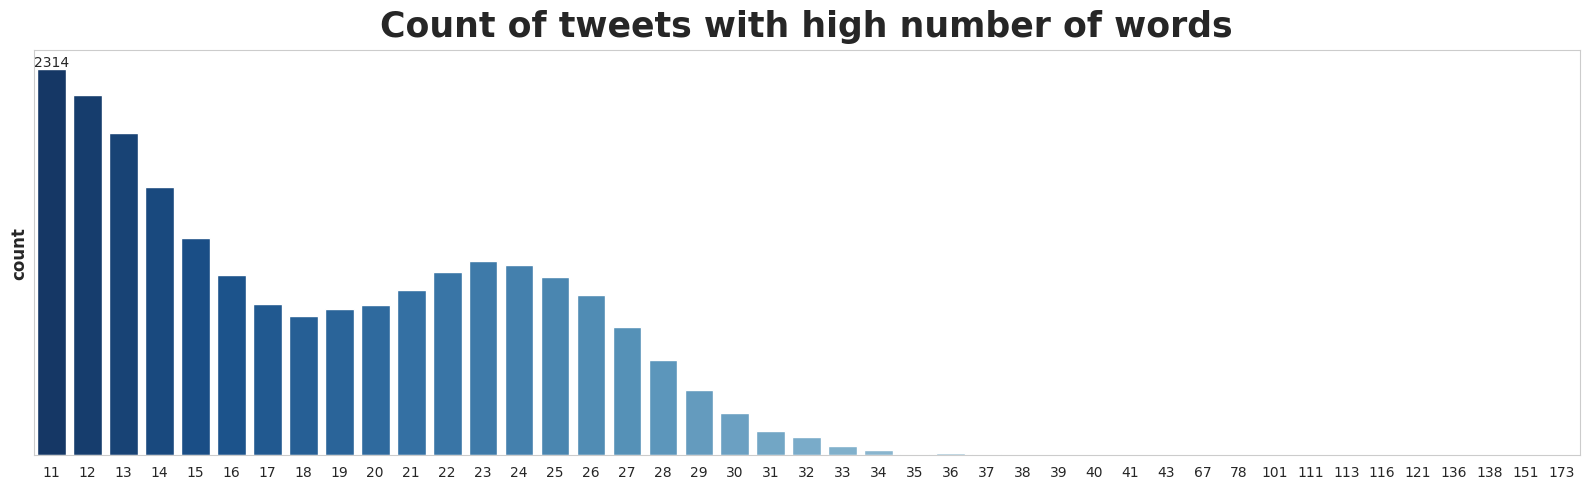

In [19]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [20]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

In [21]:
max_len = np.max(df['text_len'])
max_len

31

In [22]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

<ipython-input-22-5cd3204e082e>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})
<ipython-input-22-5cd3204e082e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})


Text tokenization

In [23]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [24]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [25]:
X = df['text_clean']
y = df['sentiment']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Text embedding with pre-trained Word2vec model

In [27]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [28]:
EMBEDDING_DIM = 200

In [29]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [30]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [31]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (37569, 200)


In [32]:
X = tokenized_column
y = df['sentiment'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Oversampling

In [34]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train))

In [216]:
X_train_os.shape

(31330, 31)

Finally, we define our preprocessed dataset and loaders

In [35]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [36]:
BATCH_SIZE = 32

In [37]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# Implementation of the classical model

In this paragraph we will implement model with classical convolution and LSTM in order to compare it with its hybrid-quantum analogue

In [38]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim )
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)

In [39]:
class ClassicalModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_classes, lstm_layers):
        super(ClassicalModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # embedded = self.conv(embedded.unsqueeze(1))
        # # Pass embeddings to LSTM
        # out, hidden = self.lstm(embedded.reshape(-1, embedded.size(1)*embedded.size(2), embedded.size(-1)), hidden)
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return h0, c0

# Implementation of the hybrid-quantum model

In [40]:
@qml.qnode(dev, interface='torch', diff_method="adjoint")
def quanvcirc(patch, weights, wires=range(num_qubits)):
    # Angle embedding of the patch (reshape to match expected size)
    qml.AngleEmbedding(patch, wires=wires, rotation='Y')

    # Apply RX rotations based on the weights
    qml.RX(weights[0][0], wires=0)
    qml.RX(weights[0][1], wires=1)
    qml.RY(weights[1][0], wires=2)
    qml.RY(weights[1][1], wires=3)

    # Apply CNOT gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])
    # Apply RY rotations based on the weights


    # Return the expectation values of Pauli-Z measurements on all qubits
    return qml.expval(qml.PauliZ(0))

In [41]:
print(qml.draw(quanvcirc)(np.ones((1, 4)), np.ones((2, 2))))

0: ─╭AngleEmbedding(M0)──RX(1.00)─╭●───────╭X─┤  <Z>
1: ─├AngleEmbedding(M0)──RX(1.00)─╰X─╭●────│──┤     
2: ─├AngleEmbedding(M0)──RY(1.00)────╰X─╭●─│──┤     
3: ─╰AngleEmbedding(M0)──RY(1.00)───────╰X─╰●─┤     

M0 = 
[[1. 1. 1. 1.]]


In [42]:
class QuanConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(QuanConv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Define weights and biases as trainable parameters
        self.weights = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size), requires_grad = True
        )

    def forward(self, input):
        # Extract dimensions
        batch_size, in_channels, input_height, input_width = input.shape

        # Calculate output dimensions
        output_height = (input_height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (input_width - self.kernel_size + 2 * self.padding) // self.stride + 1

        # Initialize output tensor
        output = torch.zeros(batch_size, self.out_channels, output_height, output_width)

        # If padding is required, add it to the input
        if self.padding > 0:
            input = F.pad(input, (self.padding, self.padding, self.padding, self.padding))

        # Perform convolution
        for b in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(output_height):
                    for w in range(output_width):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size

                        # Slice the input for the current window
                        input_slice = input[b, :, h_start:h_end, w_start:w_end]

                        # Perform element-wise multiplication and sum with bias
                        output[b, c_out, h, w] = quanvcirc(input_slice.reshape(1, self.kernel_size * self.kernel_size), self.weights[c_out].squeeze(0))
        return output

In [249]:
qdi_reps1 = 3
qdi_reps2 = 3
qdi_depth = 1

In [250]:
@qml.qnode(dev, interface='torch', diff_method="adjoint")
def qdi_circuit(weights, input_array, wires=range(num_qubits)):
    for r in range(qdi_reps1):
        for i in range(len(wires)):
            qml.RX(weights[r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        qml.Barrier()
    for d in range(qdi_depth):
        qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
        for r in range(qdi_reps2):
            for i in range(len(wires)):
                qml.RX(weights[qdi_reps1+d*r][i], wires=wires[i])
            for j in range(len(wires)-1):
                qml.CNOT(wires=[wires[j], wires[j+1]])
            qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
            qml.Barrier()
        qml.Barrier()
    return [qml.expval(qml.PauliY(w)) for w in wires]

In [251]:
print(qml.draw(qdi_circuit)(np.ones((qdi_reps1 + qdi_reps2, num_qubits)), np.ones((4, 4))))

0: ──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||
1: ──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||
2: ──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●─│───||
3: ──RX(1.00)───────╰X─╰●──||──RX(1.00)───────╰X─╰●──||──RX(1.00)───────╰X─╰●──||

──╭AngleEmbedding(M0)──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||
──├AngleEmbedding(M0)──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||
──├AngleEmbedding(M0)──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●─│───||
──╰AngleEmbedding(M0)──RX(1.00)───────╰X─╰●──||──RX(1.00)───────╰X─╰●──||──RX(1.00)───────╰X─╰●──||

───||─┤  <Y>
───||─┤  <Y>
───||─┤  <Y>
───||─┤  <Y>

M0 = 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [252]:
class HQLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_qubits):
        super(HQLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Combined weights for efficiency
        self.W_input = nn.Parameter(torch.randn(4 * num_qubits, input_size), requires_grad = True).float()
        self.W_hid = nn.Parameter(torch.randn(4 * num_qubits, hidden_size), requires_grad = True).float()
        self.W_quan = nn.Parameter(torch.randn(4, qdi_reps1 + qdi_reps2, num_qubits), requires_grad = True).float()
        self.W = nn.Parameter(torch.randn(4, hidden_size, num_qubits), requires_grad = True).float()

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        yield_input = F.linear(x, self.W_input)
        yield_hidden = F.linear(h_prev, self.W_hid)
        # Concatenate input and previous hidden state
        combined = yield_input + yield_hidden
        # combined = torch.cat((yield_input, yield_hidden), dim=1)

        # Apply linear transformation

        # Split into gates
        # combined = torch.cat([torch.stack(qdi_circuit(self.W_quan[i], combined[:, i:i*num_qubits].reshape(-1, num_qubits))) for i in range(num_qubits)], dim = 0)
        i_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[0], combined[:, :num_qubits].reshape(-1, num_qubits))).T.float(), self.W[0])
        f_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[1], combined[:, num_qubits:2*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[1])
        g_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[2], combined[:, 2*num_qubits:3*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[2])
        o_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[3], combined[:, 3*num_qubits:4*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[3])



        # combined = torch.cat((i_gate, f_gate, g_gate, o_gate), dim=0).float()
        # gates = F.linear(combined, self.W)

        # # Split into gates
        # i_gate, f_gate, g_gate, o_gate = gates.chunk(4, 0)

        # Apply non-linearities
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        g_gate = torch.tanh(g_gate)
        o_gate = torch.sigmoid(o_gate)

        # Update cell state
        c_next = (f_gate * c_prev) + (i_gate * g_gate)

        # Update hidden state
        h_next = o_gate * torch.tanh(c_next)

        return h_next, c_next


class HQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_qubits, num_layers=1):
        super(HQLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_cells = nn.ModuleList([HQLSTMCell(input_size if l==0 else hidden_size, hidden_size, num_qubits) for l in range(num_layers)])


    def forward(self, x, hidden=None):
        batch_size, seq_len, _ = x.size()

        if hidden is None:
             h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
             c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        else:
            h0, c0 = hidden

        output_seq = []

        for t in range(seq_len):
            input_t = x[:, t, :] # input at current timestep
            # print(f'step:{t}/{seq_len}, hidden:')

            new_h = []
            new_c = []

            for layer in range(self.num_layers):

                # Get hidden state for current layer
                h_t, c_t = self.lstm_cells[layer](input_t, (h0[layer], c0[layer]))

                # Update hidden states for next timestep, for current layer
                new_h.append(h_t)
                new_c.append(c_t)
                input_t = h_t # The output of current layer is input for the next

            h0 = torch.stack(new_h)
            c0 = torch.stack(new_c)
            # Append hidden state at the topmost layer
            output_seq.append(h_t.unsqueeze(1))

        # Concatenate the outputs over the sequence length
        output_seq = torch.cat(output_seq, dim=1) # output_seq is of shape (batch_size, seq_len, hidden_size)

        return output_seq, (h0, c0)


Toy hybrid-quantum model for benchmarking

In [253]:
class ToyHQModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers):
        super(ToyHQModel, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attention = Attention(hidden_dim)
        # self.conv = QuanConv2D(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.lstm = HQLSTM(embedding_dim, hidden_dim, num_qubits, lstm_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # x = self.conv(x.unsqueeze(1)).to(device)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return h0, c0

In [254]:
class HybridQuantumModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers):
        super(HybridQuantumModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = QuanConv2D(in_channels, out_channels, kernel_size, stride, padding)
        self.lstm = HQLSTM(embedding_dim, hidden_dim, num_qubits, lstm_layers)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # embedded = self.conv(embedded.unsqueeze(1)).to(device)
        # Pass embeddings to LSTM
        # out, hidden = self.lstm(embedded.reshape(-1, embedded.size(1)*embedded.size(2), embedded.size(-1)))
        out, hidden = self.lstm(embedded)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out

# Training the models

In [236]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers
IN_CHANNELS = 1
OUT_CHANNELS = 5
KERNEL_SIZE = 2
STRIDE = 1
PADDING = 1


LR = 8e-4 #Learning rate
EPOCHS = 10 #Number of training epoch

criterion = nn.NLLLoss()

In [204]:
classical_model = ClassicalModel(VOCAB_SIZE, EMBEDDING_DIM, IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, STRIDE, PADDING, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS)
classical_model = classical_model.to(device)
# classical_model = torch.compile(classical_model)

cl_optimizer = torch.optim.AdamW(classical_model.parameters(), lr=LR, weight_decay = 5e-6)

print(classical_model)

ClassicalModel(
  (embedding): Embedding(37569, 200)
  (conv): Conv2d(1, 5, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [237]:
hybrid_quantum_model = HybridQuantumModel(VOCAB_SIZE, EMBEDDING_DIM, IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, STRIDE, PADDING, HIDDEN_DIM, num_qubits, NUM_CLASSES, LSTM_LAYERS)
hybrid_quantum_model = hybrid_quantum_model.to(device)
# hybrid_quantum_model = torch.compile(hybrid_quantum_model)

hq_optimizer = torch.optim.AdamW(hybrid_quantum_model.parameters(), lr=LR, weight_decay = 5e-6)

print(hybrid_quantum_model)

HybridQuantumModel(
  (embedding): Embedding(37569, 200)
  (conv): QuanConv2D()
  (lstm): HQLSTM(
    (lstm_cells): ModuleList(
      (0): HQLSTMCell()
    )
  )
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [238]:
import time

def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            start_time = time.time()
            X = batch[0].to(device)
            y = batch[1].to(device)

            h = model.init_hidden(y.size(0))
            # model forward-pass
            preds, h = model(X, h)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step() # t = t - lr * t.grad
            end_time = time.time()
            execution_time = end_time - start_time

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            print(f'batch: {it+1}/{len(train_dataloader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            h = model.init_hidden(y.size(0))

            with torch.no_grad():
                # model forward-pass
                preds, h = model(X, h)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

def train_for_hqnn(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0

        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            start_time = time.time()
            X = batch[0].to(device)
            y = batch[1].to(device)

            # model forward-pass
            preds = model(X)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step() # t = t - lr * t.grad
            end_time = time.time()
            execution_time = end_time - start_time

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            print(f'it: {it+1}/{len(train_dataloader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss

        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)


            with torch.no_grad():
                # model forward-pass
                preds = model(X)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

In [228]:
cl_train_losses, \
    cl_test_losses, \
    cl_train_accuracy_arr, \
    cl_test_accuracy_arr = train(classical_model, criterion=criterion,
                              optimizer=cl_optimizer,
                              train_dataloader=train_loader,
                              test_dataloader=test_loader,
                              num_epochs=EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
batch: 875/979, loss: 0.0168, time: 0.0028
batch: 876/979, loss: 0.0168, time: 0.0044
batch: 877/979, loss: 0.0168, time: 0.0041
batch: 878/979, loss: 0.0168, time: 0.0030
batch: 879/979, loss: 0.0170, time: 0.0029
batch: 880/979, loss: 0.0170, time: 0.0031
batch: 881/979, loss: 0.0170, time: 0.0029
batch: 882/979, loss: 0.0170, time: 0.0028
batch: 883/979, loss: 0.0170, time: 0.0028
batch: 884/979, loss: 0.0170, time: 0.0029
batch: 885/979, loss: 0.0170, time: 0.0029
batch: 886/979, loss: 0.0170, time: 0.0030
batch: 887/979, loss: 0.0170, time: 0.0029
batch: 888/979, loss: 0.0170, time: 0.0029
batch: 889/979, loss: 0.0170, time: 0.0029
batch: 890/979, loss: 0.0169, time: 0.0029
batch: 891/979, loss: 0.0170, time: 0.0029
batch: 892/979, loss: 0.0170, time: 0.0030
batch: 893/979, loss: 0.0169, time: 0.0032
batch: 894/979, loss: 0.0170, time: 0.0036
batch: 895/979, loss: 0.0170, time: 0.0036
batch: 896/979, loss: 0.0170,

In [181]:
cl_test_accuracy_arr

array([0.93169248, 0.92823562, 0.93003319, 0.92353429, 0.92284292,
       0.92146018, 0.92063053, 0.91482301, 0.92090708, 0.91302544])

In [ ]:
hq_train_losses, \
    hq_test_losses, \
    hq_train_accuracy_arr, \
    hq_test_accuracy_arr = train_for_hqnn(hybrid_quantum_model, criterion=criterion,
                              optimizer=hq_optimizer,
                              train_dataloader=train_loader,
                              test_dataloader=test_loader,
                              num_epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

it: 1/979, loss: 1.6102, time: 139.4079


In [ ]:
hq_test_accuracy_arr

In [ ]:
hq_train_accuracy_arr

In [173]:
batch_size = 2
in_channels = 1
out_channels = 3
length = 31
num_classes = 5
kernel_size = 2
embedding_dim = 200
hidden_dim = 100
padding = 1
stride = 1
num_qubits = 4

# Create dummy data & labels
train_dummy_data = torch.randint(0, 1000, (batch_size, length)).to(device)
train_dummy_labels = torch.randint(0, num_classes, (batch_size,)).to(device)

test_dummy_data = torch.randn(batch_size, length)
test_dummy_labels = torch.randint(0, num_classes, (batch_size,))

# Create a simple Dataset and DataLoader
train_dummy_dataset = TensorDataset(train_dummy_data, train_dummy_labels)
train_dummy_loader = DataLoader(train_dummy_dataset, batch_size)

test_dummy_dataset = TensorDataset(test_dummy_data, test_dummy_labels)
test_dummy_loader = DataLoader(test_dummy_dataset, batch_size)


In [174]:
LR = 8e-4 #Learning rate

toy_hq_model = ToyHQModel(VOCAB_SIZE, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers = 1)

toy_hq_model = toy_hq_model.to(device)
# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(toy_hq_model.parameters(), lr=LR, weight_decay = 5e-6)

print(toy_hq_model)

ToyHQModel(
  (embedding): Embedding(37569, 200)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (lstm): HQLSTM(
    (lstm_cells): ModuleList(
      (0): HQLSTMCell()
    )
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [175]:
toy_hq_model(train_dummy_data)

torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])


tensor([[-1.6381, -1.6118, -1.5608, -1.6813, -1.5606],
        [-1.6472, -1.6141, -1.5558, -1.6795, -1.5565]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [126]:
print(X_train.shape)

(28985, 31)


In [127]:
# train_dummy_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
# test_dummy_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [128]:
# BATCH_SIZE = 2

In [129]:
# train_dummy_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_dummy_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [78]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train_for_hqnn(toy_hq_model, criterion=criterion,
                              optimizer=optimizer,
                              train_dataloader=train_dummy_loader,
                              test_dataloader=test_dummy_loader,
                              num_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_losses